In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../init.py

Created snorkel session from  postgres:///snorkel25similar


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
import pickle
from sqlalchemy import  or_, and_,any_
import numpy as np

In [3]:
import re
from io import StringIO

def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)


# Drop the unmapped labels

In [4]:
for k in range (3):
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, REGULATOR.gold_labels.any())).count()
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, ~REGULATOR.gold_labels.any())).count()

13007
0
3242
0
8221
0


## Load & balance dataset

In [5]:
from snorkel.annotations import load_gold_labels,load_marginals

In [6]:

train_cands  = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
val_cands  = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test_cands  = session.query(REGULATOR).filter(REGULATOR.split == 2).all()
unlab_cands = session.query(REGULATOR).filter(REGULATOR.split == 3).all()

train_labels  = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, train_cands))
val_labels  = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, val_cands))
test_labels = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, test_cands))

In [7]:
# also copied in ../MLutils.py

from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

def balance_candidates(cands, marginals, rs = 42):
    """Balance and shuffle candidates along with their (prob) labels.
    
    cands: list of candidate objects
    marginals: list of marginal (or not) labels
    rs: int: random_state (used in RandomUnderSampler and sklearn.utils.shuffle) 
    """
    rus = RandomUnderSampler(random_state=rs,return_indices=True)
    marginals_01 = np.round(marginals)

    _,_, indices = rus.fit_sample(pd.DataFrame(marginals), np.round(marginals))

    # shuffle indices
    indices = shuffle(indices, random_state = rs)

    # keep only selected items
    cands_us = [cands[i] for i in indices]
    marginals_us = [marginals[i] for i in indices]
    
    return cands_us, np.array(marginals_us)

In [8]:
train_cands_us, train_labels_us = balance_candidates(train_cands,train_labels)

# LSTM training

In [10]:
from snorkel.learning import GridSearch
from snorkel.learning import reRNN

In [11]:
# import matplotlib.pyplot as plt
# plt.hist(train_labels, bins=20)
# plt.title('Training candidates to be applied')
# plt.show()

In [12]:

#    dropout  batch_size  n_epochs     lr  max_sentence_length  rebalance  \
# 2     0.25          32        20  0.001                  128       0.25   
# 8     0.25          32         5  0.001                   64       0.25

In [13]:
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'rebalance':  False,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

lstm = reRNN(seed=1701, n_threads=None,)

# lstm.train(train_cands, train_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)
lstm.train(train_cands_us, train_labels_us, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 0 has argument past max length for model:	[arg ends at index 140; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 9 has argument past max length for model:	[arg ends at index 82; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 36 has argument past max length for model:	[arg ends at index 207; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 109 has argument past max length for model:	[arg ends at index 69; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6576  #epochs=10  batch size=32


KeyboardInterrupt: 

In [13]:
# TODO: for word embeddings look into :
# lstm.word_dict

## Plot learning curves

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer,f1_score,mean_squared_error
from scipy.sparse import vstack

In [ ]:
lstm._build_model

In [17]:
batch_size = 32
epochs=5

In [18]:
# Wrap as sklearn classifier for learning curves
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=lstm._build_model , batch_size=batch_size, epochs=epochs, verbose=1 ) #callbacks=[metrics])#, epochs=150, batch_size=10, verbose=0)


array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
train_cands_us, train_labels_us, X_dev = val_cands , Y_dev = val_labels

In [25]:
train_sizes, train_scores, valid_scores = learning_curve(
    model,
    train_cands_us + val_cands , 
    np.concatenate((train_labels_us, val_labels)), 
#     shuffle = True,
#     random_state = 2,
#     verb
    #train_sizes=range(1000, X_train.shape[0], 1000), 
    #     groups = X_all_split,
    #     scoring = mse_scorer
    
)

Exception AttributeError: "'Session' object has no attribute '_session'" in <bound method Session.__del__ of <tensorflow.python.client.session.Session object at 0x7fb4d479bc10>> ignored


AttributeError: 'NoneType' object has no attribute 'update'

# Evaluate on val/test

In [14]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, val_labels)

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 90 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 95 has argument past max length for model:	[arg ends at index 65; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 486 has argument past max length for model:	[arg ends at index 70; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 487 has argument past max length for model:	[arg ends at index 74; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel

Scores (Un-adjusted)
Pos. class accuracy: 0.561
Neg. class accuracy: 0.84
Precision            0.495
Recall               0.561
F1                   0.526
----------------------------------------
TP: 398 | FP: 406 | TN: 2126 | FN: 312



In [15]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, test_labels)

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 89 has argument past max length for model:	[arg ends at index 73; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 466 has argument past max length for model:	[arg ends at index 67; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 523 has argument past max length for model:	[arg ends at index 96; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 524 has argument past max length for model:	[arg ends at index 96; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorke

Scores (Un-adjusted)
Pos. class accuracy: 0.541
Neg. class accuracy: 0.842
Precision            0.522
Recall               0.541
F1                   0.532
----------------------------------------
TP: 1074 | FP: 983 | TN: 5254 | FN: 910



## Determine sentence length statistics (for LSTM hidden units)

In [16]:
def get_sentence_length(candidate):
    """Get sentence length of a certain candidate"""
    return len(candidate.get_parent().entity_types)

Text(0.5,1,'Sentence length histogram (words)')

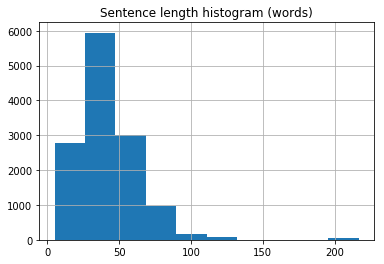

In [17]:
lengths = pd.Series(list(map(lambda x: get_sentence_length(x),train_cands)))
lengths.hist()
plt.title("Sentence length histogram (words)")

# Grid Search

In [18]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

In [20]:
from snorkel.learning import RandomSearch, GridSearch
from snorkel.learning import SparseLogisticRegression

seed = 1234
num_model_search = 10

# search over this parameter grid
param_grid = {}
# param_grid['batch_size'] = [32, 64]
# param_grid['lr']         = [1e-3, 1e-2]
# param_grid['dropout'] = [0.25,0.5]
# param_grid['rebalance']  = [0.0, 0.25]

param_grid['max_sentence_length']  = [32, 64, 128]

param_grid['batch_size'] = [32]
param_grid['lr']         = [1e-3]
param_grid['dropout'] = [0.25]
param_grid['rebalance']  = [0.0, 0.25]
param_grid['n_epochs'] = [5,10,20]


model_hyperparams = {
#     'n_epochs': 20,
    'print_freq': 5,
    'dev_ckpt_delay': 0.5,
    'X_dev': val_cands,
    'Y_dev': val_labels
}

model_class_params = {
    'seed': seed,
    'n_threads':1
}

# Undersampling
searcher = RandomSearch(reRNN, param_grid, train_cands_us, train_marginals_us,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

In [ ]:
print "Discriminitive Model Parameter Space (seed={}):".format(seed)
for i, params in enumerate(searcher.search_space()):
    print i, params

disc_model, run_stats = searcher.fit(X_valid=val_cands, Y_valid=val_labels, n_threads=1)
print run_stats

# Predict on val & unlab 

In [21]:
import pickle

In [22]:
with open(path_candidate_dict_pkl, 'rb') as f:
    cands = pickle.load(f)

In [23]:
# from snorkel.learning import reRNN

# lstm = reRNN(seed=1701, n_threads=None,)

In [24]:
# # lstm.load(model_name='reRNN_14',save_dir="checkpoints/grid_search/")
# disc_model=lstm

# export results_dict

In [25]:
from sklearn.metrics import classification_report, f1_score

In [26]:
results_dict = {}

In [33]:

# Validation
val_pred = lstm.predictions(val_cands) # needed for class_report
val_pred_prob = lstm.marginals(val_cands)
val_ids = list(map(lambda x: x.id ,val_cands))
# Test
# test_pred = lstm.predictions(test_cands)
test_pred_prob = lstm.marginals(test_cands)
test_ids = list(map(lambda x: x.id ,test_cands))
# Unlabelled
# unlab_pred = lstm.predictions(unlab_cands)
unlab_pred_prob = lstm.marginals(unlab_cands)
unlab_ids = list(map(lambda x: x.id ,unlab_cands))

# do it with 
val_ground_truth = list(map(lambda x: cands[1][x]['label'], val_ids))
test_ground_truth = list(map(lambda x: cands[2][x]['label'], test_ids))

class_report = report_to_df(classification_report(val_ground_truth, val_pred))

results_dict['biLSTM'] = {'label_val_prob+' :dict(zip(val_ids,val_pred_prob)),
                          'label_test_prob+' :dict(zip(test_ids,test_pred_prob)),
                          'label_unlab_prob+' :dict(zip(unlab_ids,unlab_pred_prob)),
                          "classification_report": class_report,
                          'f1+': f1_score(val_ground_truth, val_pred)
                         }

In [34]:
results_dict.keys()

['biLSTM']

In [37]:
with open(path_base_learners+'biLSTM,RuS,lr=0.001,dropout=0.25,10epochs,max_sent_length=64.pkl', 'wb') as f:
    pickle.dump(results_dict, f)